In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path
#%matplotlib qt
%matplotlib inline

In [2]:
def undistort(img,mtx,dist,verbose= False):
    ##calculate the distortion coffecient and calibration matrix use cv2.calibrateCamera
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    ##undistort input images
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    
    if verbose:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
        
    return undist
    

In [3]:
def cam_calibration(image_dir,nx,ny,verbose=False):
    
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    # Step through the list and search for chessboard corners
    
    
    # make a list of calibration images
    images= glob.glob(os.path.join(image_dir,"calibration*.jpg"))
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)       
        if verbose:
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #cv2.imshow('img',img)
            plt.imshow(img)
            #cv2.waitKey(500)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret,mtx,dist,rvecs,tvecs



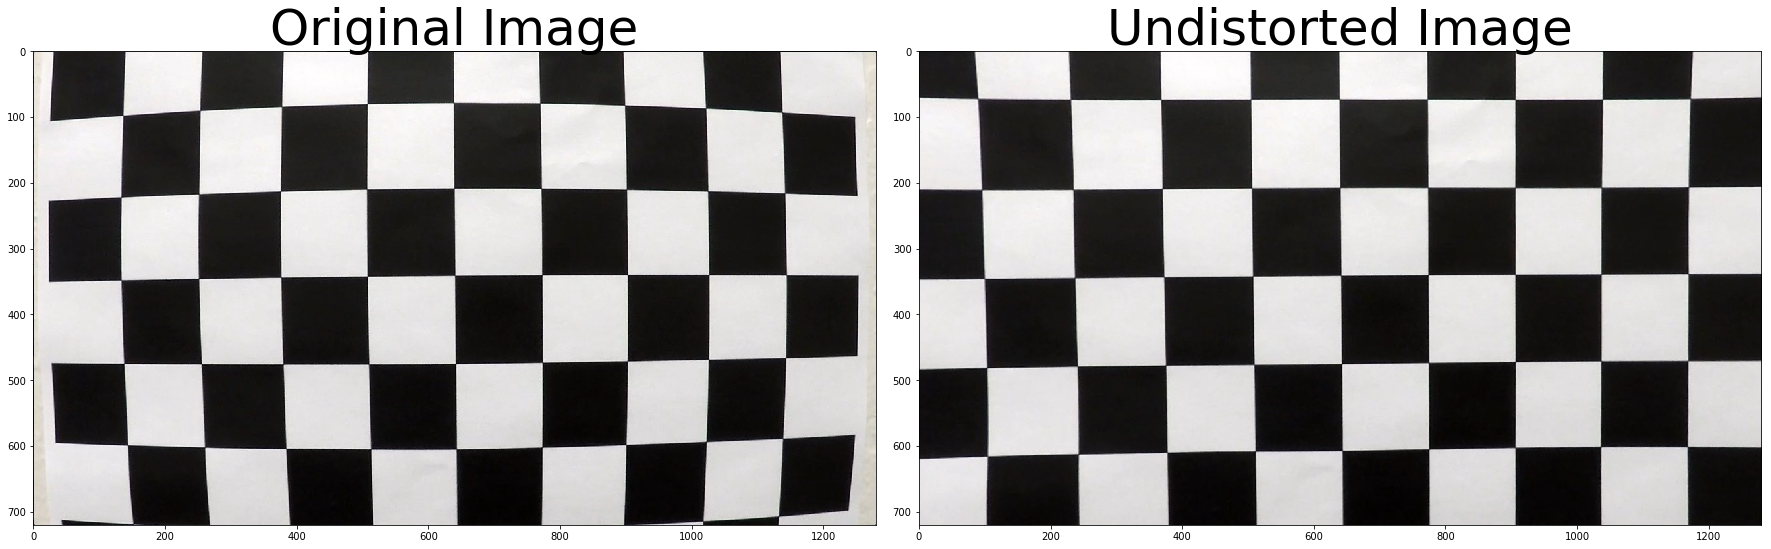

In [4]:
### Test with one raw image under folder ../camera_cal
ret,mtx,dist,rvecs,tvecs= cam_calibration(image_dir="../camera_cal/",nx=9,ny=6)

test_image= mpimg.imread("../camera_cal/calibration1.jpg")
#print("image before undistort")
#plt.imshow(test_image)
#undistorted_test_image=undistort(test_image,mtx,dist)
undistorted_test_image=undistort(test_image,mtx,dist,verbose= True)



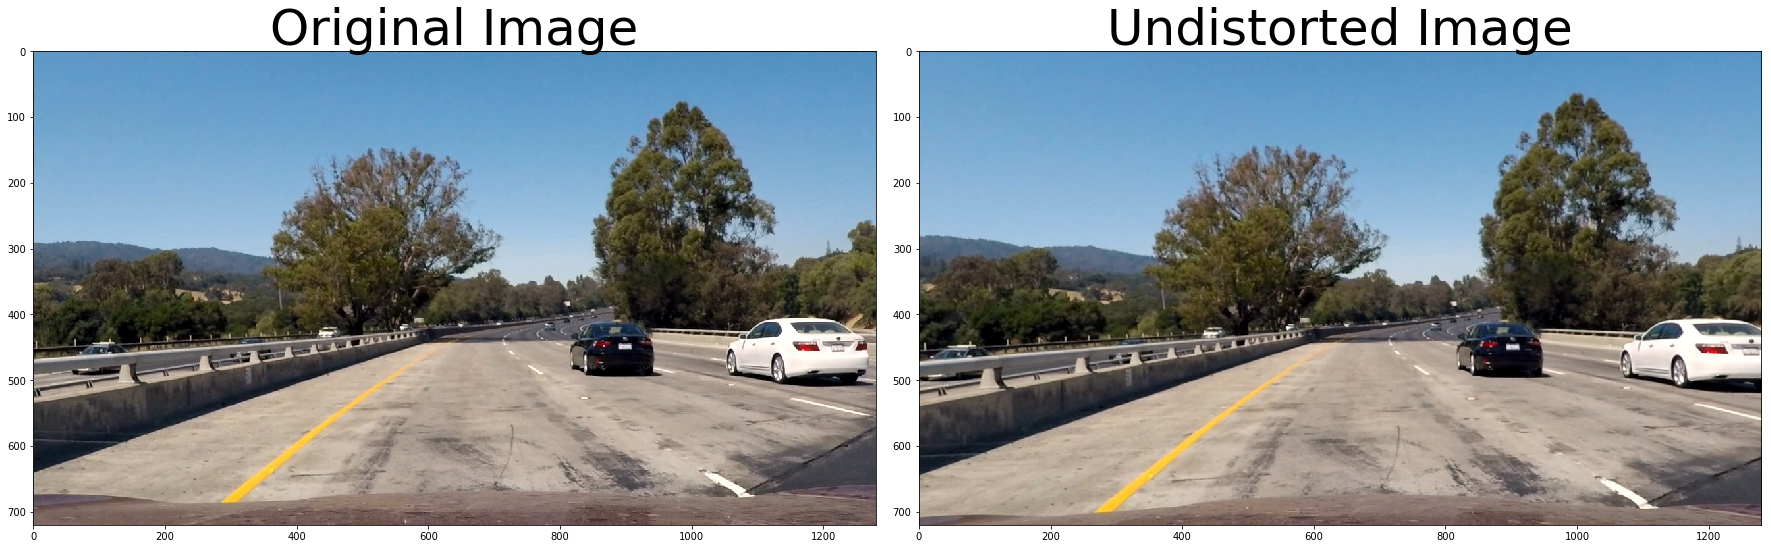

In [5]:
test_img= mpimg.imread("../test_images/test1.jpg")


undistorted_img=undistort(test_img,mtx,dist,verbose= True)
difference= undistorted_img-test_img


Text(0.5,1,'difference')

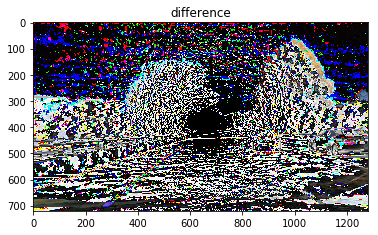

In [6]:
plt.imshow(difference)
plt.title("difference")

In [7]:
def abs_sobel_thresh(img, orient='x', thresh=[0,255]):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray_img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=="x":
        sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    elif orient=="y":
        sobelx= cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output
    
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    ##Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread().
    ##Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().
     # 1) Convert to grayscale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
     # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
     # 3) Calculate the magnitude 
    abs_sobelxy=np.sqrt(sobelx**2+sobely**2)
      # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    abs_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
     # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(abs_sobelxy)
    binary_output[(abs_sobelxy >= mag_thresh[0]) & (abs_sobelxy <= mag_thresh[1])] = 1
     # 6) Return this mask as binary_output image
    return binary_output


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
      # 1) Convert to grayscale
    gray_img= cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
     # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    sobely=cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the x and y gradients
    sobelx=np.absolute(sobelx)
    sobely=np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    grad=np.arctan2(sobely,sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(grad)
    binary_output[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    return binary_output

def compute_sobel_thresh(image,ksize,verbose=False):
    gradx = abs_sobel_thresh(image, orient='x', thresh=(25, 255))
    grady = abs_sobel_thresh(image, orient='y', thresh=(25, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 2.0))
    
    if verbose:
        f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(gradx,cmap="gray")
        ax1.set_title('Gradx', fontsize=50)
        ax2.imshow(grady,cmap="gray")
        ax2.set_title('Grady', fontsize=50)
        ax3.imshow(mag_binary,cmap="gray")
        ax3.set_title('mag_binary', fontsize=50)
        ax4.imshow(dir_binary,cmap="gray")
        ax4.set_title('dir_binary', fontsize=50)
        
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return gradx, grady, mag_binary,dir_binary





In [22]:
def combined_sobel_gradient(grady,mag_binary):
    return cv2.bitwise_or(gradx, mag_binary)

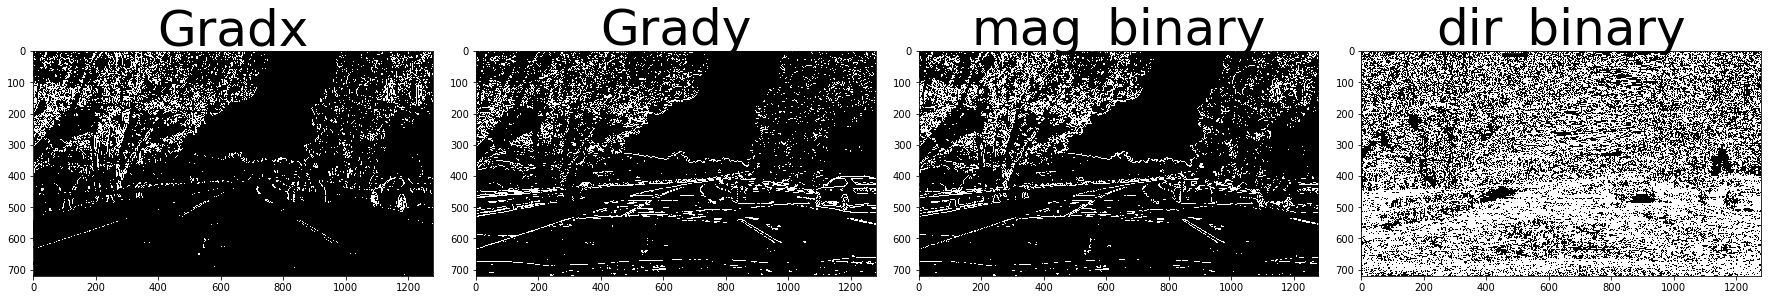

In [23]:
test_img= mpimg.imread("../test_images/test5.jpg")
gradx,grady,mag_binary,dir_binary=compute_sobel_thresh(test_img,ksize=3,verbose= True)

In [24]:
def color_space_visualize(img,convert,name):
    convert_color= cv2.cvtColor(img,convert)
    plt.figure()
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        img_channel= convert_color[:,:,i]
        plt.imshow(255*(img_channel/np.max(img_channel)), cmap='gray')
        plt.axis('off')
        
    plt.title(name)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
        
    

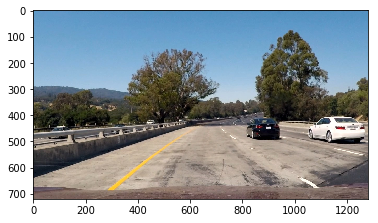

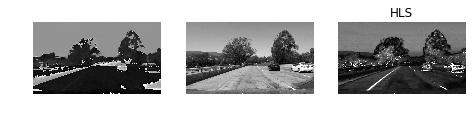

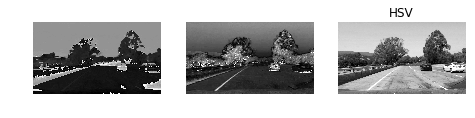

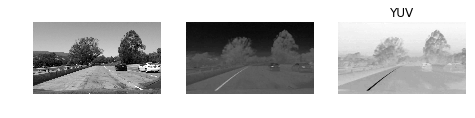

In [25]:
test_img= mpimg.imread("../test_images/test1.jpg")
plt.figure()
plt.imshow(test_img)

#rgb_visualize=color_space_visualize(test_img,cv2.COLOR_BGR2RGB,"RGB")
hls_visualize=color_space_visualize(test_img,cv2.COLOR_RGB2HLS,"HLS")
hsv_visualize=color_space_visualize(test_img,cv2.COLOR_RGB2HSV,"HSV")
yuv_visualize=color_space_visualize(test_img,cv2.COLOR_RGB2YUV,"YUV")



In [26]:
def extract_yellow(image,thresh,verbose=False):##[170,255]
    ### s_channel of HLS is the most important for yellow extraction.
    hls_image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    s_channel=hls_image[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    if verbose:
        plt.figure()
        plt.imshow(s_binary,cmap="gray")
        plt.title("extract_yellow_binary")
        
    return s_binary
    
    #yellow_lower = np.array([15,50,170])
    #yellow_upper = np.array([25,200,255])
    #return cv2.inRange(img_hls, yellow_lower, yellow_upper) // 255
def extract_yellow_update(image,verbose=False):
    hls_image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    yellow_lower = np.array([15,50,100])
    yellow_upper = np.array([25,200,255])
    
    extract_yellow_binary=cv2.inRange(hls_image, yellow_lower, yellow_upper) // 255
    if verbose:
        plt.figure()
        plt.imshow(extract_yellow_binary,cmap="gray")
        plt.title("extract_yellow_binary")
        
    return extract_yellow_binary

In [27]:
def extract_white(image,verbose=False):
    hls_image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    white_lower = np.array([0,  200, 0])
    white_upper = np.array([255,255, 255])
    
    extract_white_binary=cv2.inRange(hls_image, white_lower, white_upper) // 255
    if verbose:
        plt.figure()
        plt.imshow(extract_white_binary,cmap="gray")
        plt.title("extract_white_binary")
        
    return extract_white_binary



In [28]:
def combined_color_mask(image,verbose=False):
    yellow_binary=extract_yellow_update(image)
    white_binary=extract_white(image)
    color_mask=cv2.bitwise_or(yellow_binary, white_binary)
    
    if verbose:
        plt.imshow(color_mask,cmap="gray")
        plt.title("combined_color_mask")
        
    return color_mask



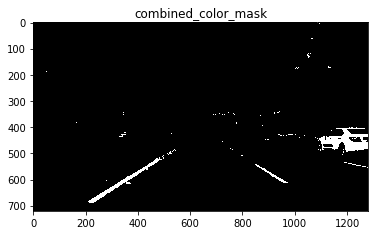

In [29]:
test_img= mpimg.imread("../test_images/test5.jpg")
#yellow_binary=extract_yellow(test_img,thresh=[170,255],verbose= True)
#yellow_binary=extract_yellow_update(test_img,verbose= True)
#white_binary=extract_white(test_img,verbose= True)
#color_mask = cv2.bitwise_or(yellow_binary, white_binary)
color_mask=combined_color_mask(test_img,verbose=True)
#plt.figure()
#plt.imshow(color_mask,cmap="gray")
#plt.title("combined_color_mask")




In [30]:
def final_mask_combination(img,verbose=False):###yellow_thresh[170,255]
    #yellow_binary=extract_yellow_update(img,verbose= False)
    #white_binary=extract_white(img,verbose= False)  
    color_mask = combined_color_mask(img)
    
    ##then compute the sobel gradient thresh.
    gradx,grady,mag_binary,dir_binary=compute_sobel_thresh(img,ksize=3,verbose=False)
    #combined_sobel_mask=combined_sobel_gradient(gradx,mag_binary)
    Final_mask=cv2.bitwise_or(color_mask,gradx)
    #Final_mask=mask_to_rgb(Final_mask)
    #Final_mask= cv2.bitwise_or(color_mask,combined_sobel_mask)
    
    if verbose:
        plt.imshow(Final_mask,cmap="gray")
    return Final_mask

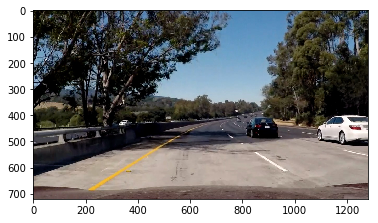

In [42]:
test_img= mpimg.imread("../test_images/test5.jpg")
plt.figure()
plt.imshow(test_img)

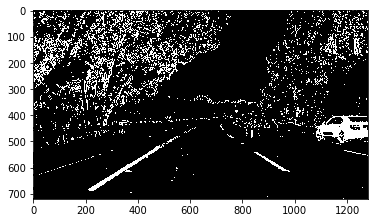

In [43]:
final_mask=final_mask_combination(test_img,verbose= True)

In [168]:
def perspect_trans(img,verbose=False):
    ####apply perspective transform to get the birdview of image
    img_size=(img.shape[1],img.shape[0])
    x1=205
    x2=1100
    y_rough=460
    offset= 100
    

    src=((x1,img.shape[0]),(x2,img.shape[0]),(700,y_rough),(585,y_rough))

    dst=((x1+offset,img.shape[0]),(x2-offset,img.shape[0]),(x2-offset,0),(x1+offset,0))
    
    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    Minv = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(warped)
    
    
    if verbose:
        #image_visual=img.copy()
        for i in range(4):
            img=cv2.line(img,src[i],src[(i+1)%4], color=[255,0,0],thickness=4)
            warped=cv2.line(warped,dst[i],dst[(i+1)%4], color=[255,0,0],thickness=4)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(warped,cmap="gray")
        ax2.set_title('BirdEye Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return Minv,warped

In [37]:
def mask_to_rgb(img):
    return 255 * np.dstack((img, img, img))

(720, 1280, 3)


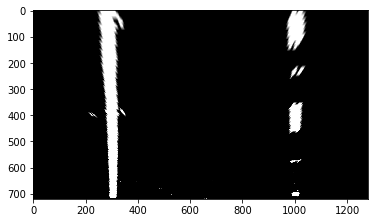

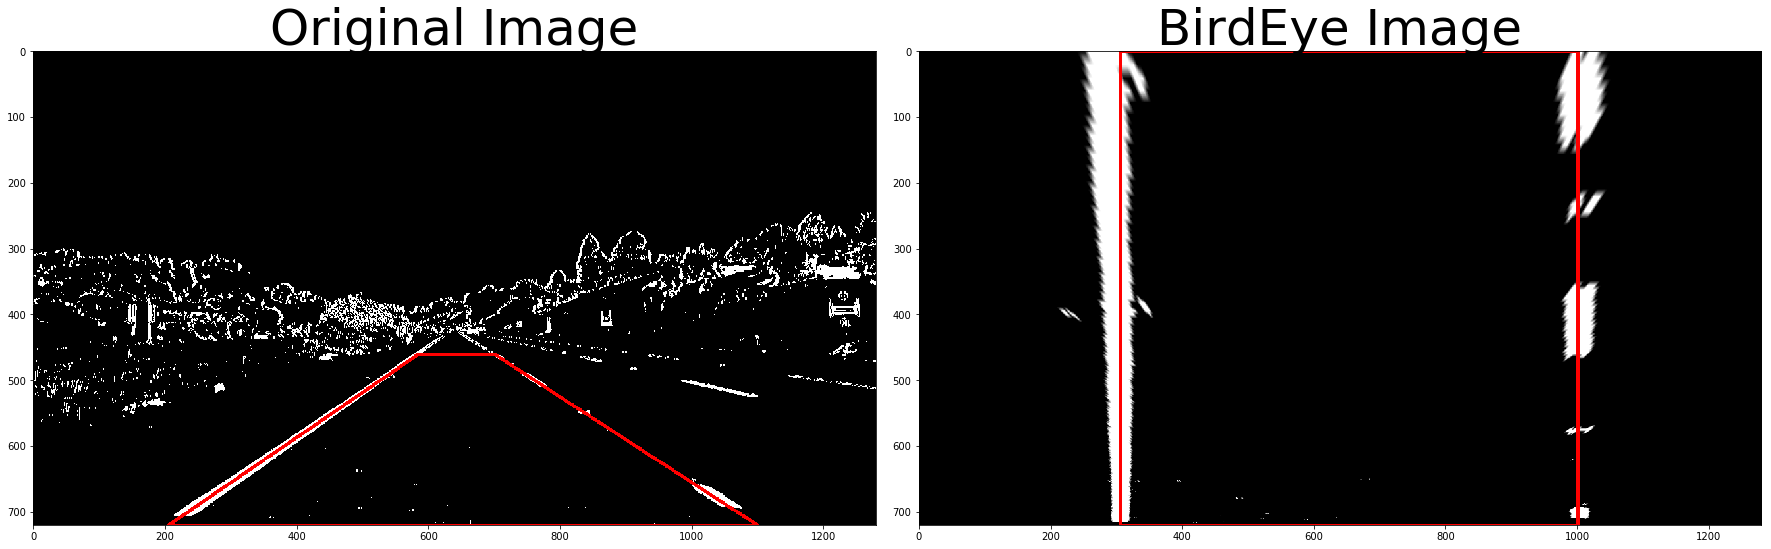

In [62]:
##define roi region
test_img= mpimg.imread("../test_images/straight_lines1.jpg")
#plt.imshow(test_img)
undistorted_test=undistort(test_img,mtx,dist)
undistorted_test=final_mask_combination(undistorted_test)
undistorted_test=mask_to_rgb(undistorted_test)
plt.imshow(undistorted_test)
print(undistorted_test.shape)
warped=perspect_trans(undistorted_test,verbose=True)




(720, 1280)
(3, 3)


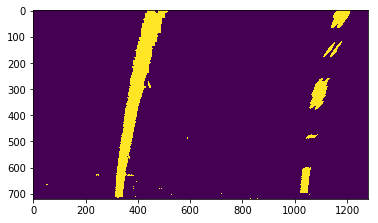

In [169]:
##define roi region
test_img= mpimg.imread("../test_images/test3.jpg")
plt.imshow(test_img)
undistorted_test=undistort(test_img,mtx,dist)
undistorted_test=final_mask_combination(undistorted_test)
undistorted_test_rgb=mask_to_rgb(undistorted_test)
plt.imshow(undistorted_test_rgb)
print(undistorted_test.shape)
#warped_rgb,Minv=perspect_trans(undistorted_test_rgb)
Minv,wraped=perspect_trans(undistorted_test)####undistorted_test is binary image, not reconstruct in rgb color space
print(warped.shape)




## Lane Pixels detection

In [101]:
def get_startx(img,visualize=False):
    ##first draw histogram
    histogram= np.sum(warped[warped.shape[0]//2:,:],axis=0)

    
    ####Get left and right peaks, Assuming that left and right lines will be on the left of right half of the image.
    
    midpoint=int(len(histogram)/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint  
    print(midpoint)
    print(np.argmax(histogram[0:midpoint]))##leftx_base
    print(np.argmax(histogram[midpoint:]) + midpoint)##rightx_base


    
    if visualize:
        plt.plot(histogram)
        plt.autoscale(enable=True,axis="x",tight=True)
        
    return leftx_base,rightx_base
    

(3, 3)
3
1
0
2


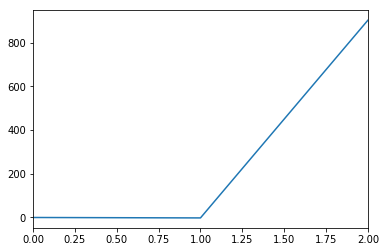

In [170]:
histogram= np.sum(warped[warped.shape[0]//2:,:],axis=0)
plt.plot(histogram)
plt.autoscale(enable=True,axis="x",tight=True)
print(warped.shape)

print(len(histogram))
midpoint=int(len(histogram)/2)
print(midpoint)
print(np.argmax(histogram[0:midpoint]))##leftx_base
print(np.argmax(histogram[midpoint:]) + midpoint)##rightx_base


## Lane fitting

In [122]:
import numpy as np
from collections import deque

In [123]:
class Line():
    ##define a class to retrieve the characteristics of each line detection
    def __init__(self,buffer_len=10):
        ### flag to mark if the line was detected the last iteration
        self.detected=False
        ####
        self.radius_of_curvature=None
        ####polynomial coefficients fitted on the last i
        self.last_fit_pixel=None
        self.last_fit_meter=None
        # list of polynomial coefficients of the last N iterations
        self.recent_fits_pixel = collections.deque(maxlen=buffer_len)
        self.recent_fits_meter = collections.deque(maxlen=2 * buffer_len)
        
        
        # store all pixels coords (x, y) of line detected
        self.all_x = None
        self.all_y = None
        
    def update_lines(self,new_fit_pixel,new_fit_meters,detected,clear_buff=False):
        ###Update Line with new fitted coefficients.
        ###:param new_fit_pixel: new polynomial coefficients (pixel)
        ###:param new_fit_meter: new polynomial coefficients (meter)
        ###:param detected: if the Line was detected or inferred
        ###:param clear_buffer: if True, reset state
        ##:return: None
        self.detected=detected
        if clear_buff:
            self.recent_fits_pixel=[]
            self.recent_fits_meter=[]
            
            
        self.last_fit_pixel=new_fit_pixel
        self.last_fit_meter=new_fit_meters
        
        self.recent_fits_pixel.append(self.last_fit_pixel)
        self.recent_fits_meter.append(self.last_fit_meter)
        
        
        
    def draw(self, mask, color=(255, 0, 0), line_width=50, average=False):
        
        h, w, c = mask.shape

        plot_y = np.linspace(0, h - 1, h)
        coeffs = self.average_fit if average else self.last_fit_pixel

        line_center = coeffs[0] * plot_y ** 2 + coeffs[1] * plot_y + coeffs[2]
        line_left_side = line_center - line_width // 2
        line_right_side = line_center + line_width // 2

        # Some magic here to recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array(list(zip(line_left_side, plot_y)))
        pts_right = np.array(np.flipud(list(zip(line_right_side, plot_y))))
        pts = np.vstack([pts_left, pts_right])

        # Draw the lane onto the warped blank image
        return cv2.fillPoly(mask, [np.int32(pts)], color)
    
    
    def average_fit(self):
        return np.mean(self.recent_fits_pixel, axis=0)
    
    def curvature(self):
        y_eval = 0
        coeffs = self.average_fit
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])
    
    def curvature_meter(self):
        y_eval = 0
        coeffs = np.mean(self.recent_fits_meter, axis=0)
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])


            
        
        
        


        
        
        
        

In [127]:
def histogram_lanelines(wraped,left_line,right_line,nwindows=9,visualise=False):
    height,width=wraped_image.shape
    window_height = np.int(height/nwindows)
    out_img=np.dstack((warped,warped,warped))*255
    histogram= np.sum(warped[height//2:,:],axis=0)
    midpoint=int(len(histogram)/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    windows=[]  ##record search window for visualization
    margin=100
    minpix=50
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window+1)*window_height
        #win_y_high = binary_warped.shape[0] - window*window_height
        win_y_high = 720 - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),4)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),4)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    left_line.all_x = nonzerox[left_lane_inds]
    left_line.all_y = nonzeroy[left_lane_inds] 
    right_line.all_x = nonzerox[right_lane_inds]
    right_line.all_y= nonzeroy[right_lane_inds] 
    
    
    
    detected=True
    if not list(left_line.all_x) or not list(left_line.all_y):
        left_fit_pixel=left_line.last_fit_pixel
        left_fit_meter=left_line.last_fit_meter
        detected= False
        
    else:
        left_fit_pixel=np.polyfit(left_line.all_y,left_line.all_x,2)
        left_fit_meter = np.polyfit(left_line.all_y * ym_per_pix, left_line.all_x * xm_per_pix, 2)
        
        
        
    if not list(right_line.all_x) or not list(right_line.all_y):
        right_fit_pixel=right_line.last_fit_pixel
        right_fit_meter=right_line.last_fit_meter
        detected= False
        
    else:
        right_fit_pixel=np.polyfit(right_line.all_y,right_line.all_x,2)
        right_fit_meter = np.polyfit(right_line.all_y * ym_per_pix, right_line.all_x * xm_per_pix, 2)
        
        
    left_line.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    right_line.update_line(right_fit_pixel, right_fit_meter, detected=detected)
    ploty = np.linspace(0,warped.shape[0]-1,warped.shape[0])
    left_fitx = left_fit_pixel[0]*ploty**2 + left_fit_pixel[1]*ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0]*ploty**2 + right_fit_pixel[1]*ploty + right_fit_pixel[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if visualise:
        plt.imshow(out_img)
        print(out_img.shape)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        
    return left_line,right_line,out_img
        
   

In [ ]:
def previous_lanelines(warped,left_line,right_line,visualize=False):
    ####left_line: Previous detected left lines
    ####right_line:Previous detected right lines
    height,width=warped.shape
    left_fit_pixel=left_line.last_fit_pixel
    right_fit_pixel=right_line.last_fit_pixel
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin=100
    left_lane_inds = (
    (nonzero_x > (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] - margin)) & (
    nonzero_x < (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] + margin)))
    right_lane_inds = (
    (nonzero_x > (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] - margin)) & (
    nonzero_x < (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] + margin)))
    left_line.all_x = nonzerox[left_lane_inds]
    left_line.all_y = nonzeroy[left_lane_inds] 
    right_line.all_x = nonzerox[right_lane_inds]
    right_line.all_y= nonzeroy[right_lane_inds] 
    detected=True
    if not list(left_line.all_x) or not list(left_line.all_y):
        left_fit_pixel=left_line.last_fit_pixel
        left_fit_meter=left_line.last_fit_meter
        detected= False
        
    else:
        left_fit_pixel=np.polyfit(left_line.all_y,left_line.all_x,2)
        left_fit_meter = np.polyfit(left_line.all_y * ym_per_pix, left_line.all_x * xm_per_pix, 2)
        
        
        
    if not list(right_line.all_x) or not list(right_line.all_y):
        right_fit_pixel=right_line.last_fit_pixel
        right_fit_meter=right_line.last_fit_meter
        detected= False
        
    else:
        right_fit_pixel=np.polyfit(right_line.all_y,right_line.all_x,2)
        right_fit_meter = np.polyfit(right_line.all_y * ym_per_pix, right_line.all_x * xm_per_pix, 2)
        
        
    left_line.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    right_line.update_line(right_fit_pixel, right_fit_meter, detected=detected)
    ploty = np.linspace(0,warped.shape[0]-1,warped.shape[0])
    left_fitx = left_fit_pixel[0]*ploty**2 + left_fit_pixel[1]*ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0]*ploty**2 + right_fit_pixel[1]*ploty + right_fit_pixel[2]
    
    out_img=np.dstack((warped,warped,warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    
    if visualize:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        plt.show()
        
        
    return left_line,right_line,out_img
   

In [ ]:
def draw_back(undistorted_image, left_line,right_line,)

In [ ]:
def convolution_lanelines(self,wraped,left_fit,right_fit):
        ## find line around known previous lines
        ##left fit, right fit: previously fitted left,right lines.
        out_img=np.dstack((warped,warped,warped))*255
        windows_width=50
        ##windows_height=80##break image into 9 vertical layers since image height is 720
        hww=25##half of window width
        nwindows=9
        window_height = np.int(height/nwindows)
        
        margin=100
        window_centroids=[]
        window=np.ones(windows_width)
        offset=np.int((windows_width+margin)/2)
        
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        
        left_lane_inds = []
        right_lane_inds = []
        
        for level in range(1,nwindows):
            y_min=np.int(level*window_height)
            y_max=np.int(y_min+window_height)
            layer=warped[y_min:y_max,:]
            image_layer=np.sum(layer,axis=0)
            conv_signal=np.convolve(window,image_layer)
            
            y_eval=(y_min+y_max)/2
            l_base=np.int(left_fit[0]*y_eval**2+left_fit[1]*y_eval+left_fit[2])
            l_base=max(0,min(self.width,l_base))
            l_center=(np.argmax(conv_signal[max(0,l_base-offset):min(self.width,l_base+offset)])+l_base-offset-hww)
            
            r_base=np.int(right_fit[0]*y_eval**2+right_fit[1]*y_eval+right_fit[2])
            r_base=max(0,min(self.width,r_base))
            r_center=(np.argmax(conv_signal[max(0,r_base-offset):min(self.width,r_base+offset)])+r_base-offset-hww)
            
            window_centroids.append((l_center,r_center))
            
            good_left_inds=((nonzeroy>=y_min)&(nonzeroy<=y_max)&(nonzerox>=(l_center-hww))&(nonzerox<=(l_center+hww))).nonzero()[0]
            good_right_inds=((nonzeroy>=y_min)&(nonzeroy<=y_max)&(nonzerox>=(r_center-hww))&(nonzerox<=(r_center+hww))).nonzero()[0]
            
            
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
        left_lane_inds=np.concatenate(left_lane_inds)
        right_lane_inds=np.concatenate(right_lane_inds)
        
        
        # Extract left and right line pixel positions,all positions for left and right lines.
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        return left_fit,right_fit
    

640
347
1048
(array([  0,   0,   0, ..., 719, 719, 719]), array([435, 436, 437, ..., 857, 858, 881])) [435 436 437 ... 857 858 881] [  0   0   0 ... 719 719 719]
347 1048
[ 1.33335289e-04 -2.97581507e-01  4.70730124e+02]


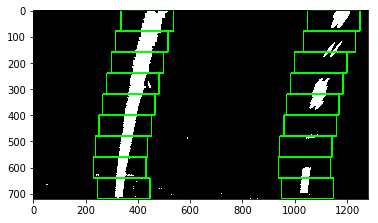

In [141]:
leftx_base,rightx_base=get_startx(warped)
#out_img=warped.copy()
out_img=np.dstack((warped,warped,warped))*255
nwindows = 9
window_height = np.int(warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
print(nonzero,nonzerox,nonzeroy)
leftx_current = leftx_base
rightx_current = rightx_base
print(leftx_current,rightx_current)
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = 720 - (window+1)*window_height
    #win_y_high = binary_warped.shape[0] - window*window_height
    win_y_high = 720 - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),4)
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),4)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


plt.imshow(out_img)
print(left_fit)
    

(720, 1280, 3)


(720, 0)

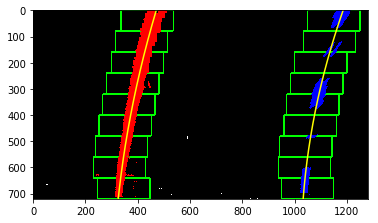

In [142]:

ploty = np.linspace(0,warped.shape[0]-1,warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
print(out_img.shape)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)





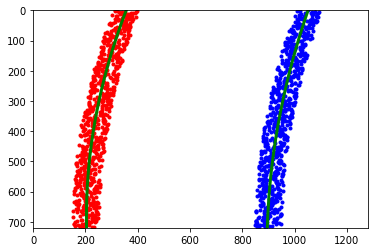

In [148]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [149]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1539.4058053217047 1979.8423653807909


In [150]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

505.2266701891048 m 649.1411862862076 m


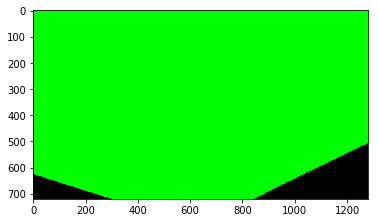

In [154]:
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (1280, 720))
plt.imshow(newwarp)
#result = cv2.addWeighted(test_img, 1, newwarp, 0.3, 0)
#plt.imshow(result)